In [76]:
from tqdm import tqdm
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [77]:
num_words_list = [50000, 20000, 5000]

def load_dataset(num_words_list):
    X_trains = []
    y_trains = []
    X_tests = []
    y_tests = []
    
    for num_words in num_words_list:
        (X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
        
        word_index = reuters.get_word_index(path="reuters_word_index.json")
        index_to_word = {index+3 : word for word, index in word_index.items() }
        for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
            index_to_word[index]=token
            
        decoded = []
        for i in range(len(X_train)):
            temp = ' '.join([index_to_word[index] for index in X_train[i]])
            decoded.append(temp)
        X_trains.append(decoded)
        
        decoded = []
        for i in range(len(X_test)):
            temp = ' '.join([index_to_word[index] for index in X_test[i]])
            decoded.append(temp)
        X_tests.append(decoded)
        
        y_trains.append(y_train)
        y_tests.append(y_test)
    return X_trains, y_trains, X_tests, y_tests

In [78]:
dtmvector = CountVectorizer()
tfidf_transformer = TfidfTransformer()

def tfidf_transform(X_trains, X_tests):
    tfidf_X_trains = []
    tfidf_X_tests = []
    
    for X_train, X_test in zip(X_trains, X_tests):
        x_train_dtm = dtmvector.fit_transform(X_train)
        tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
        tfidf_X_trains.append(tfidfv)
        
        x_test_dtm = dtmvector.transform(X_test)
        tfidfv_test = tfidf_transformer.transform(x_test_dtm)
        tfidf_X_tests.append(tfidfv_test)
    
    return tfidf_X_trains, tfidf_X_tests

In [79]:
def get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test):
    model.fit(tfidf_X_train, y_train)
    predicted = model.predict(tf_idf_X_test)
    acc = accuracy_score(y_test, predicted)
    return acc

In [80]:
model_list = ["Naive Bayse", 
              "Complement Naive Bayes Classifier", 
              "Logistic Regression", 
              "Linear Support Vector Machine", 
              "Decision Tree", 
              "Random Forest", 
              "GradientBoostingClassifier", 
              "Voting"]

def test_machine_learning(tfidf_X_train, y_train, tf_idf_X_test, y_test, num_words):
    accuarcy = []
    
    model = MultinomialNB()
    accuarcy.append(get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test))
    
    model = ComplementNB()
    accuarcy.append(get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test))
    
    model = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
    accuarcy.append(get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test))
    
    model = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
    accuarcy.append(get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test))
    
    model = DecisionTreeClassifier(max_depth=10, random_state=0)
    accuarcy.append(get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test))
    
    model = RandomForestClassifier(n_estimators=5, random_state=0)
    accuarcy.append(get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test))
    
    model = GradientBoostingClassifier(random_state=0)
    accuarcy.append(get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test))
    
    
    model = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
    ], voting='soft')
    accuarcy.append(get_acc(model, tfidf_X_train, y_train, tf_idf_X_test, y_test))
    
    print("="*65)
    print("num_words : {}".format(num_words))
    for i in range(len(model_list)):
        print("{} accuacy : {}".format(model_list[i], accuarcy[i]))
    print("="*65)
    print()
    print()
    print()
    
    return accuarcy

In [81]:
#20000, 5000
X_trains, y_trains, X_tests, y_tests = load_dataset(num_words_list)
tfidf_X_trains, tfidf_X_tests = tfidf_transform(X_trains, X_tests)

acc = []
for i in tqdm(range(3)):
    acc.append(test_machine_learning(tfidf_X_trains[i], y_trains[i], tfidf_X_tests[i], y_tests[i], num_words_list[i]))


  0%|          | 0/3 [00:00<?, ?it/s]

(8982, 26506)
(2246, 26506)


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 1/3 [1:00:54<2:01:48, 3654.12s/it]

num_words : 50000
Naive Bayse accuacy : 0.5997328584149599
Complement Naive Bayes Classifier accuacy : 0.7649154051647373
Logistic Regression accuacy : 0.8165627782724845
Linear Support Vector Machine accuacy : 0.7880676758682101
Decision Tree accuacy : 0.6219946571682992
Random Forest accuacy : 0.6527159394479074
GradientBoostingClassifier accuacy : 0.7707034728406055
Voting accuacy : 0.8201246660730187



(8982, 18479)
(2246, 18479)


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|██████▋   | 2/3 [1:56:17<57:39, 3459.28s/it]  

num_words : 20000
Naive Bayse accuacy : 0.6193232413178985
Complement Naive Bayes Classifier accuacy : 0.7671415850400712
Logistic Regression accuacy : 0.8156723063223509
Linear Support Vector Machine accuacy : 0.7858414959928762
Decision Tree accuacy : 0.6211041852181657
Random Forest accuacy : 0.6714158504007124
GradientBoostingClassifier accuacy : 0.7702582368655387
Voting accuacy : 0.8192341941228851



(8982, 4867)
(2246, 4867)


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 3/3 [2:38:20<00:00, 3166.89s/it]

num_words : 5000
Naive Bayse accuacy : 0.6731967943009796
Complement Naive Bayes Classifier accuacy : 0.7707034728406055
Logistic Regression accuacy : 0.8036509349955476
Linear Support Vector Machine accuacy : 0.769813000890472
Decision Tree accuacy : 0.6179875333926982
Random Forest accuacy : 0.701246660730187
GradientBoostingClassifier accuacy : 0.767586821015138
Voting accuacy : 0.8103294746215495





In [126]:
acc_data = pd.DataFrame(acc, columns=model_list, index=num_words_list)
acc_data

,Naive Bayse,Complement Naive Bayes Classifier,Logistic Regression,Linear Support Vector Machine,Decision Tree,Random Forest,GradientBoostingClassifier,Voting
50000,0.599733,0.764915,0.816563,0.788068,0.621995,0.652716,0.770703,0.820125
20000,0.619323,0.767142,0.815672,0.785841,0.621104,0.671416,0.770258,0.819234
5000,0.673197,0.770703,0.803651,0.769813,0.617988,0.701247,0.767587,0.810329


2376
145.5398574927633


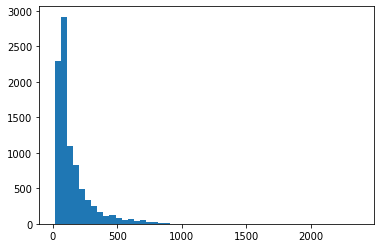

In [128]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=20000, test_split=0.2)
print(max(len(l) for l in x_train))
print(sum(map(len, x_train))/len(x_train))

plt.hist([len(s) for s in x_train], bins=50)
plt.show()

In [129]:
X_train_temp = X_train
y_train_temp = y_train
X_test_temp = X_test
y_test_temp = y_test
for i, (x, y) in enumerate(zip(X_train_temp, y_train_temp)):
    if len(x) > 200:
        np.delete(X_train, i, axis=0)
        np.delete(y_train, i, axis=0)
        
for i, (x, y) in enumerate(zip(X_test_temp, y_test_temp)):
    if len(x) > 200:
        np.delete(X_test, i, axis=0)
        np.delete(y_test, i, axis=0)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 512)         10240000  
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 512)         2099200   
_________________________________________________________________
lstm_13 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 46)                11822     
Total params: 13,204,270
Trainable params: 13,204,270
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
18/18 [==============================] - 14s 621ms/step - loss: 2.8246 - accuracy: 0.3098 - val_l

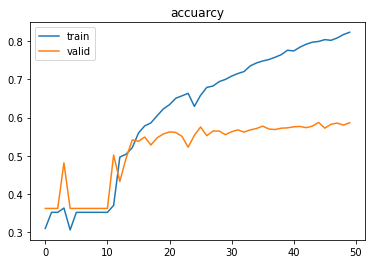

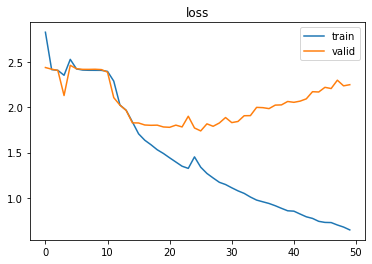

In [130]:
num_classes = max(y_train) + 1

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        padding="pre", 
                                                        maxlen=200)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                        padding="pre", 
                                                        maxlen=200)
y_train = tf.one_hot(y_train, num_classes)
y_test = tf.one_hot(y_test, num_classes)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(20000, 512))
model.add(tf.keras.layers.LSTM(512, return_sequences=True))
model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()

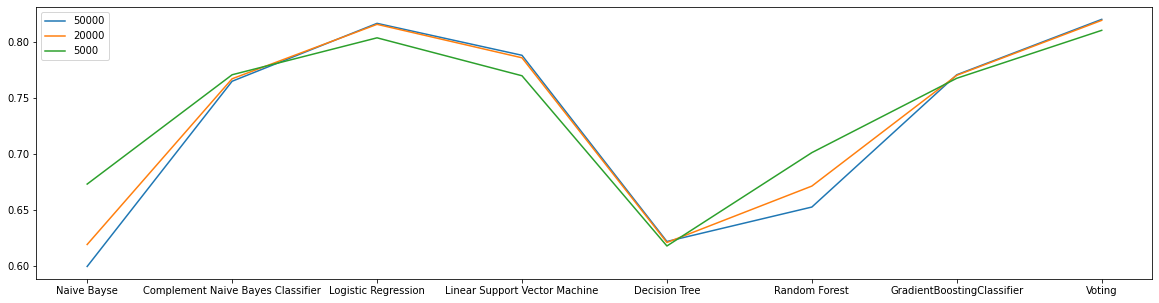

In [127]:
acc_data = acc_data.transpose()
plt.figure(figsize=(20, 5))
plt.plot(acc_data, label=num_words_list)
plt.legend()
plt.show()